<a href="https://colab.research.google.com/github/QuickLearner171998/Weighted-RNN-for-News-Text-Classification/blob/master/WRNN_News_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
% cd "/content/drive/My Drive/nnfl_project/"

In [0]:
%tensorflow_version 1.x
from sklearn.datasets import fetch_20newsgroups
from keras.utils import to_categorical
import os
import glob
import numpy as np
import pickle
from tqdm import tqdm
from keras.layers import Activation, Dense, Embedding, Flatten, LSTM, Input, Reshape, Conv1D
from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import load_model, Model
from keras.optimizers import Adam


PATH = '/content/drive/My Drive/nnfl_project/'
DATA_PATH = '/content/drive/My Drive/nnfl_project/data'
GLOVE_PATH = '/content/drive/My Drive/glove.840B.300d.txt'

In [0]:
def clean_data(docs):
  pass

def text_length_selection(docs, theta = 0.85):
  """ 
  Input-
    doc : newsgroups_train.data - list of strings 
    theta - threshold - 0.85(as in the paper)
  Output-
    sl
  """
  # list having number of words in each document.
  DL = [len(docs[i].split()) for i in range(len(docs))]
  DNum =len(DL)
  sort_DL = sorted(DL)
  for SL in set(sort_DL):
    thresh = sort_DL.index(SL)/DNum
    if(thresh>=theta):
      return SL

def tokenize_sequences(texts, sl):

  tokenizer = Tokenizer(oov_token='<UNK>')
  tokenizer.fit_on_texts(texts)

  sequences = tokenizer.texts_to_sequences(texts)
  sequences = pad_sequences(sequences, maxlen=sl)

  return tokenizer, sequences

def get_data(data_path):
  newsgroups_data = fetch_20newsgroups(data_path, subset='all')
  labels = newsgroups_data.target
  texts = newsgroups_data.data
  return labels, texts

def get_epoch_frm_model_file(save_path):
  return int(save_path[:save_path.index('_')])
  # return int(save_path.split('_')[2])

def return_last_saved_model(paths):
  last_epoch_prev = -1
  ret_path = ""
  for path in paths:
    last_epoch = get_epoch_frm_model_file(path)
    if(last_epoch >= last_epoch_prev):
      last_epoch_prev = last_epoch
      ret_path = path
  return ret_path


In [0]:
def get_embedding_matrix(tokenizer, path, embedding_dim):
    """
    :param path: path to the glove embeddings file
    :param tokenizer: tokenizer fitted on the documents
    :param vocab_size: vocabulary size 
    :return: an embedding matrix: a nn.Embeddings
    """
    # Load the GloVe vectors into a dictionary, keeping only words in vocab
    # embedding_dim = 300
    # glove_path = "/content/drive/My Drive/glove.840B.300d.txt"
    glove_path = path
    glove_vectors = {}
    glove_file = open(glove_path, 'r')
    for line in tqdm(glove_file):
        split_line = line.rstrip().split()
        word = split_line[0]
        if len(split_line) != (embedding_dim + 1) or word not in tokenizer.word_index:
            continue
        assert (len(split_line) == embedding_dim + 1)
        vector = np.array([float(x) for x in split_line[1:]], dtype="float32")
        assert len(vector) == embedding_dim
        glove_vectors[word] = vector

    glove_file.close()

    print("Number of pre-trained word vectors loaded: ", len(glove_vectors))

    # Calculate mean and stdev of embeddings
    all_embeddings = np.array(list(glove_vectors.values()))
    embeddings_mean = float(np.mean(all_embeddings))
    embeddings_stdev = float(np.std(all_embeddings))

    vocab_size = len(tokenizer.word_index)
    # Randomly initialize an embedding matrix of (vocab_size, embedding_dim) shape
    # with a similar distribution as the pretrained embeddings for words in vocab.
    embedding_matrix = np.random.normal(embeddings_mean, embeddings_stdev, (vocab_size, embedding_dim))

    for i, word in enumerate(tokenizer.word_index):
        if word in glove_vectors:
            embedding_matrix[i] = glove_vectors[word]

    return embedding_matrix

In [0]:
# in paper
embed_dim = 300 
hidden_dim  = 128
batch_size  = 128
epochs = 100
init_epoch = 0
sl = 300


In [0]:

save_embedding_matrix_path = PATH + 'embedding_matrix.pkl'

labels, texts = get_data(DATA_PATH)
tokenizer, tokenized_seq = tokenize_sequences(texts, sl)
vocab_size = len(tokenizer.word_index)

In [7]:
if(glob.glob(save_embedding_matrix_path)):
  print('Embedding matrix found. Loading ...')
  with open(save_embedding_matrix_path, 'rb') as f:
    embedding_matrix = pickle.load(f)

  print('Done.')

else:
  embedding_matrix = get_embedding_matrix(tokenizer, GLOVE_PATH, embed_dim)
  with open(save_embedding_matrix_path, 'wb+') as f:
    pickle.dump(embedding_matrix, f)


Embedding matrix found. Loading ...
Done.


In [0]:
# convert labels to one hot
labels = to_categorical(np.asarray(labels))
output_dim = labels.shape[1]

In [9]:
print(tokenized_seq.shape)
print(labels.shape)
vocab_size

(18846, 300)
(18846, 20)


179210

In [0]:
# inp = Input(shape=(sl,))
# embed = Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[embedding_matrix], input_length=sl, trainable=False)(inp)
# # print(embed.shape)
# lstm = LSTM(hidden_dim,return_sequences=True)(embed)
# # print(lstm.shape)
# tensors = []
# for i in range(sl):
#   w_m = Lambda(lambda x: x[:, i, :], output_shape=(hidden_dim,))(lstm)
#   # w_m = Lambda(lambda x: x[:, i, :], output_shape=(sl,))(lstm)
#   w_i = Dense(1, activation='relu')(w_m)
#   prod = multiply([w_m, w_i])
#   tensors.append(prod)

# wd = add(tensors)
# # dense1 = Dense(1,activation='relu',activity_regularizer=l1_l2(0.01))(lstm)
# # print(dense1.shape)
# # f = Flatten()(wd)
# dense2 = Dense(hidden_dim, activation='relu' ,activity_regularizer=l1_l2(0.01))(wd)
# out = Dense(output_dim, activation='softmax')(dense2)
# model = Model(input = inp, outputs = out)
# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01),metrics=['accuracy'])

In [0]:

# # create model

# inp = Input(shape= (sl,))
# embed = Embedding(input_dim=vocab_size, output_dim=embed_dim, weights= [embedding_matrix], input_length=sl, trainable = False )(inp)
# lstm = LSTM(hidden_dim,return_sequences=True,recurrent_dropout=0.2,dropout=0.2)(embed) # o/p 300x128
# # Note o/p of a rnn cel or lstm cell gives prob of each word - (300,)
# # conv 1d inp shape - (128,300) -- reshape needed
# f1 = Flatten()(lstm)
# r2 = Reshape((hidden_dim,sl))(f1)
# conv1d = Conv1D(hidden_dim,1,activation='relu' )(r2)
# f = Flatten()(conv1d)
# d = Dense(hidden_dim,activation='relu')(f)
# out = Dense(output_dim, activation='softmax', activity_regularizer=l1_l2(0.01,0.01))(d)
# model = Model(input = inp, outputs = out)
# model.summary()


In [13]:
inp = Input(shape= (sl,))
embed = Embedding(input_dim=vocab_size, output_dim=embed_dim, weights= [embedding_matrix], input_length=sl, trainable = True )(inp)
lstm = LSTM(hidden_dim,return_sequences=True,recurrent_dropout=0.2,dropout=0.2)(embed) # o/p 300x128
f1 = Flatten()(lstm)
r2 = Reshape((hidden_dim,embed_dim))(f1)
conv1d = Conv1D(1, 1, activation='relu' )(r2)
f = Flatten()(conv1d)
d = Dense(hidden_dim,activation='relu')(f)
out = Dense(output_dim, activation='softmax', activity_regularizer=l1_l2(0.01,0.01))(d)
model = Model(input = inp, outputs = out)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 300)          53763000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 128)          219648    
_________________________________________________________________
flatten_5 (Flatten)          (None, 38400)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 128, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 1)            301       
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


In [19]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005),metrics=['categorical_accuracy'])


# check if a saved_model exists
if(glob.glob('*.hdf5')):
  print("loading model")
  load_path = return_last_saved_model(glob.glob('*.hdf5'))
  # model=load_model(load_path)
  model.load_weights(load_path)
  init_epoch = get_epoch_frm_model_file(load_path)

chk_pth = "{epoch:02d}_.hdf5"

# early stopping
earlyStop = EarlyStopping(monitor='val_categorical_accuracy', mode='auto', verbose=1,patience=5)
checkpoint = ModelCheckpoint(chk_pth,monitor='val_categorical_accuracy', verbose=1, save_weights_only=True, save_best_only='False',mode = 'auto', period=2)

print("START TRAINING")

history = model.fit(tokenized_seq,labels,epochs=init_epoch+epochs, batch_size=batch_size, validation_split=0.1,shuffle = True, callbacks=[checkpoint,earlyStop], initial_epoch=init_epoch)
print("Training fininshed....Saving Model")
save_path = "{}_epochs-model_weights.hdf5".format(init_epoch+epochs)
model.save_weights(save_path)



loading model
START TRAINING
Train on 16961 samples, validate on 1885 samples
Epoch 21/120
16961/16961 [==============================] - 78s 5ms/step - loss: 2.2725 - categorical_accuracy: 0.9988 - val_loss: 2.6550 - val_categorical_accuracy: 0.8154
Epoch 22/120
16961/16961 [==============================] - 76s 4ms/step - loss: 2.2843 - categorical_accuracy: 0.9976 - val_loss: 2.6606 - val_categorical_accuracy: 0.8143

Epoch 00022: val_categorical_accuracy improved from -inf to 0.81432, saving model to 22_.hdf5
Epoch 23/120
16961/16961 [==============================] - 76s 5ms/step - loss: 2.2858 - categorical_accuracy: 0.9959 - val_loss: 2.6305 - val_categorical_accuracy: 0.8302
Epoch 24/120
16961/16961 [==============================] - 76s 4ms/step - loss: 2.2830 - categorical_accuracy: 0.9965 - val_loss: 2.6243 - val_categorical_accuracy: 0.8302

Epoch 00024: val_categorical_accuracy improved from 0.81432 to 0.83024, saving model to 24_.hdf5
Epoch 25/120
16961/16961 [===========

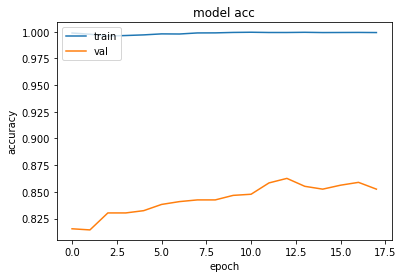

In [20]:
# plot
# plot model
import matplotlib.pyplot as plt
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [21]:
history.history.keys()

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])

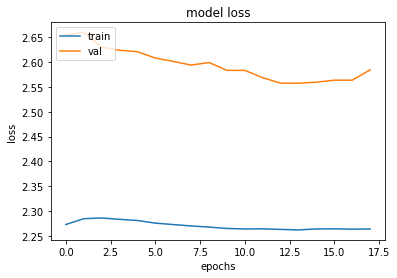

In [22]:
# plot
# plot model
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
